In [ ]:
pip install facenet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 121.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 97.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.

In [ ]:
import kagglehub
import shutil
import os

# Download dataset
path = kagglehub.dataset_download("ciplab/real-and-fake-face-detection")
print("Original Path to dataset files:", path)

# Define destination path
destination = "/content/Dataset"

# Use copytree instead of move
if not os.path.exists(destination):
    shutil.copytree(path, destination)
    print("Dataset copied to:", destination)
else:
    print("Destination already exists.")

100%|██████████| 431M/431M [00:06<00:00, 72.1MB/s]

Extracting files...


Original Path to dataset files: /root/.cache/kagglehub/datasets/ciplab/real-and-fake-face-detection/versions/1
Dataset copied to: /content/Dataset


In [ ]:
import shutil
import os

folder_path = '/content/Dataset/real_and_fake_face_detection'

if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print(f"Deleted folder: {folder_path}")
else:
    print(f"Folder does not exist: {folder_path}")


Deleted folder: /content/Dataset/real_and_fake_face_detection


In [ ]:
!pip install transformers torchvision

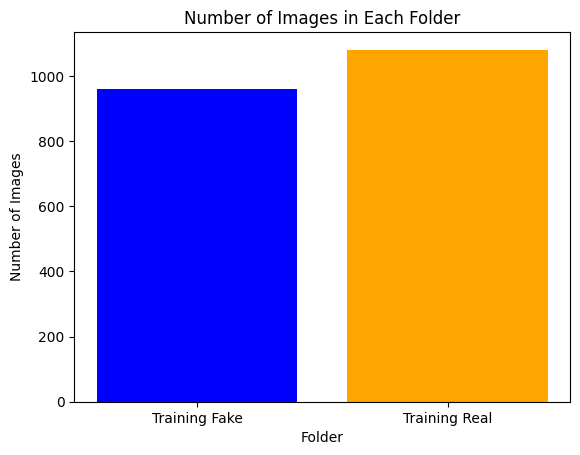

In [ ]:
import os
import matplotlib.pyplot as plt

folders = {
    "Training Fake": '/content/Dataset/real_and_fake_face/training_fake',
    "Training Real": '/content/Dataset/real_and_fake_face/training_real'
}

# Count the number of images in each folder
folder_counts = {folder_name: len([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))])
                 for folder_name, folder_path in folders.items()}

# Display the results as a bar graph
plt.bar(folder_counts.keys(), folder_counts.values(), color=['blue', 'orange'])
plt.title('Number of Images in Each Folder')
plt.xlabel('Folder')
plt.ylabel('Number of Images')
plt.show()

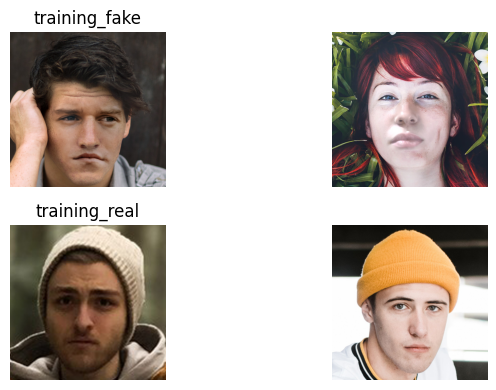

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

def show_sample_images(data_dir, classes, num_images=2):
    fig, axes = plt.subplots(len(classes), num_images, figsize=(8, 4))

    for i, cls in enumerate(classes):
        cls_path = os.path.join(data_dir, cls)
        images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.png'))][:num_images]

        for j, img_name in enumerate(images):
            img_path = os.path.join(cls_path, img_name)
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(cls)

    plt.tight_layout()
    plt.show()

# Define data_dir and classes before calling the function
data_dir = '/content/Dataset/real_and_fake_face'  # Replace with your actual data directory
classes = ['training_fake', 'training_real']  # Replace with your class names

show_sample_images(data_dir, classes)


In [ ]:
import os
import cv2
import torch
import numpy as np
from PIL import Image
from facenet_pytorch import MTCNN

# === Paths ===
input_dirs = {
    'real': '/content/Dataset/real_and_fake_face/training_real',
    'fake': '/content/Dataset/real_and_fake_face/training_fake'
}
output_root = '/content/CroppedFaces'

# === Setup MTCNN ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(keep_all=False, device=device)

# === Utility: Check and sharpen blurry images ===
def is_blurry(image_path, threshold=50):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None: return True
    return cv2.Laplacian(img, cv2.CV_64F).var() < threshold

def sharpen_image(img_bgr):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edges_rgb = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
    return cv2.addWeighted(img_rgb, 1.5, edges_rgb, -0.5, 0)

# === Main Loop ===
for label, input_path in input_dirs.items():
    output_path = os.path.join(output_root, label)
    os.makedirs(output_path, exist_ok=True)

    for filename in os.listdir(input_path):
        file_path = os.path.join(input_path, filename)
        try:
            # Sharpen if blurry
            if is_blurry(file_path):
                img_bgr = cv2.imread(file_path)
                if img_bgr is None:
                    continue
                img_rgb = sharpen_image(img_bgr)
            else:
                img_rgb = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2RGB)

            img_pil = Image.fromarray(img_rgb)

            # Detect face using MTCNN
            face_tensor = mtcnn(img_pil)
            if face_tensor is not None:
                face_img = (face_tensor.permute(1, 2, 0).clamp(0, 1) * 255).byte().cpu().numpy()
                cropped = Image.fromarray(face_img).resize((224, 224))
                cropped.save(os.path.join(output_path, filename))
            else:
                print(f"No face detected: {filename}")
        except Exception as e:
            print(f"Error with {filename}: {e}")

print("✅ Face cropping complete.")


No face detected: real_00319.jpg
No face detected: real_00692.jpg
No face detected: real_00696.jpg
No face detected: real_00818.jpg
No face detected: real_00672.jpg
No face detected: real_00951.jpg
No face detected: mid_328_0011.jpg
✅ Face cropping complete.


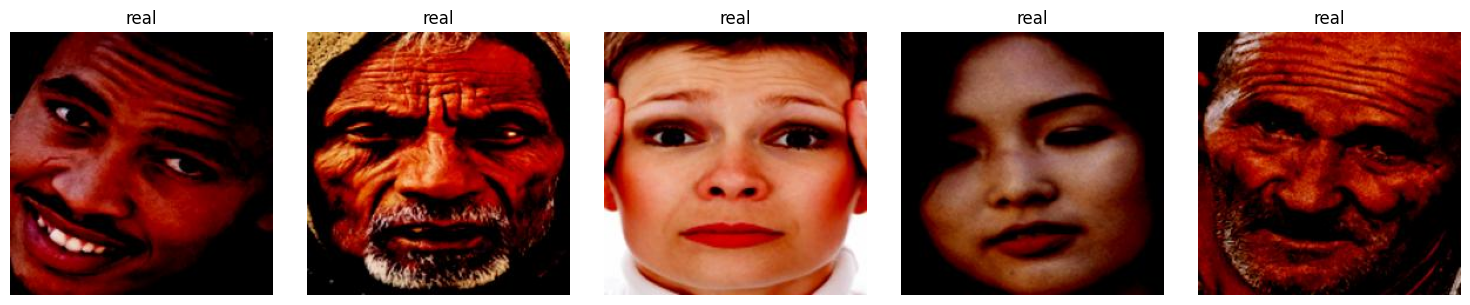

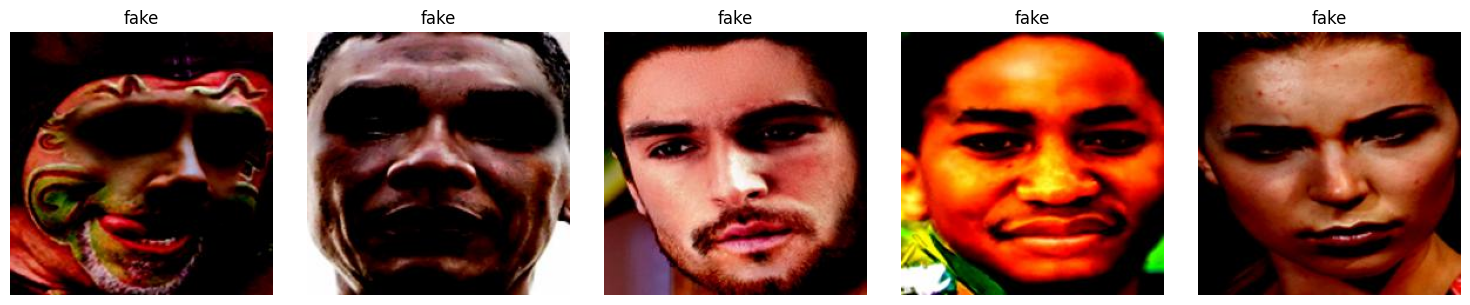

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import random
import os

def visualize_samples(base_path, label, num=5):
    path = os.path.join(base_path, label)
    images = random.sample(os.listdir(path), num)
    fig, axes = plt.subplots(1, num, figsize=(15, 3))
    for i, img in enumerate(images):
        img_path = os.path.join(path, img)
        axes[i].imshow(Image.open(img_path))
        axes[i].axis('off')
        axes[i].set_title(label)
    plt.tight_layout()
    plt.show()

# Visualize 5 from each class
visualize_samples('/content/CroppedFaces', 'real')
visualize_samples('/content/CroppedFaces', 'fake')

In [ ]:
import shutil

original_path = '/content/Dataset'
if os.path.exists(original_path):
    shutil.rmtree(original_path)
    print("🗑️ Original Dataset deleted.")

🗑️ Original Dataset deleted.


In [ ]:
from sklearn.model_selection import train_test_split

source_path = "/content/CroppedFaces"
target_base = "/content/FaceSplit"

for split in ["train", "test"]:
    for cls in ["real", "fake"]:
        os.makedirs(os.path.join(target_base, split, cls), exist_ok=True)

# Perform the actual split
for cls in ["real", "fake"]:
    full_list = os.listdir(os.path.join(source_path, cls))
    train_imgs, test_imgs = train_test_split(full_list, test_size=0.2, random_state=42)

    for img in train_imgs:
        shutil.copy(os.path.join(source_path, cls, img), os.path.join(target_base, 'train', cls, img))
    for img in test_imgs:
        shutil.copy(os.path.join(source_path, cls, img), os.path.join(target_base, 'test', cls, img))

print("✅ Cropped face dataset split into train/test.")

✅ Cropped face dataset split into train/test.


In [ ]:
def count_images(base_path):
    for split in ['train', 'test']:
        print(f"\n🔸 {split.upper()} SET")
        for cls in ['real', 'fake']:
            path = os.path.join(base_path, split, cls)
            count = len(os.listdir(path))
            print(f"{cls.capitalize()} images: {count}")

count_images("/content/FaceSplit")


🔸 TRAIN SET
Real images: 860
Fake images: 767

🔸 TEST SET
Real images: 215
Fake images: 192


In [ ]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

image_size = 224  # works for ViT and most CNNs

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder("/content/FaceSplit/train", transform=train_transforms)
test_dataset = datasets.ImageFolder("/content/FaceSplit/test", transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("✅ Data augmentation + loaders ready.")
print(f"Train set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

✅ Data augmentation + loaders ready.
Train set size: 1627
Test set size: 407


In [ ]:
from transformers import ViTForImageClassification
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ViT
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")
model.classifier = nn.Linear(model.classifier.in_features, 2)
model.to(device)

# Optimizer and loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/50, Loss: 0.7038
Epoch 2/50, Loss: 0.6853
Epoch 3/50, Loss: 0.6853
Epoch 4/50, Loss: 0.6678
Epoch 5/50, Loss: 0.6494
Epoch 6/50, Loss: 0.6207
Epoch 7/50, Loss: 0.5932
Epoch 8/50, Loss: 0.5627
Epoch 9/50, Loss: 0.5255
Epoch 10/50, Loss: 0.4917
Epoch 11/50, Loss: 0.4070
Epoch 12/50, Loss: 0.3338
Epoch 13/50, Loss: 0.2996
Epoch 14/50, Loss: 0.2609
Epoch 15/50, Loss: 0.2590
Epoch 16/50, Loss: 0.2294
Epoch 17/50, Loss: 0.2464
Epoch 18/50, Loss: 0.2157
Epoch 19/50, Loss: 0.2050
Epoch 20/50, Loss: 0.1745
Epoch 21/50, Loss: 0.1553
Epoch 22/50, Loss: 0.1504
Epoch 23/50, Loss: 0.1584
Epoch 24/50, Loss: 0.1480
Epoch 25/50, Loss: 0.1625
Epoch 26/50, Loss: 0.1450
Epoch 27/50, Loss: 0.1515
Epoch 28/50, Loss: 0.1528
Epoch 29/50, Loss: 0.1358
Epoch 30/50, Loss: 0.1501
Epoch 31/50, Loss: 0.1358
Epoch 32/50, Loss: 0.1402
Epoch 33/50, Loss: 0.1391
Epoch 34/50, Loss: 0.1337
Epoch 35/50, Loss: 0.1284
Epoch 36/50, Loss: 0.1361
Epoch 37/50, Loss: 0.1316
Epoch 38/50, Loss: 0.1368
Epoch 39/50, Loss: 0.

In [ ]:
# Save the full model (state_dict only)
model_save_path = "/content/vit_deepfake_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"✅ Model saved at: {model_save_path}")

✅ Model saved at: /content/vit_deepfake_model.pth


✅ Classification Report (Real=0, Fake=1):

              precision    recall  f1-score   support

        fake       0.73      0.77      0.75       192
        real       0.78      0.74      0.76       215

    accuracy                           0.75       407
   macro avg       0.75      0.75      0.75       407
weighted avg       0.76      0.75      0.75       407

✅ Overall Accuracy: 75.43%
✅ ROC-AUC: 0.8319


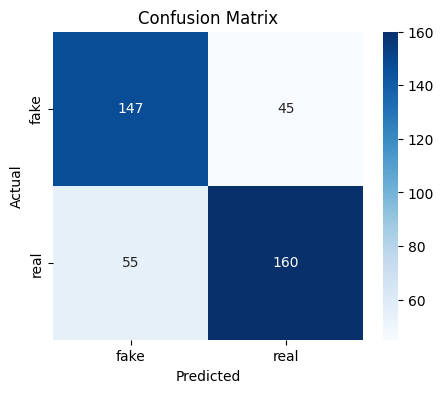

In [ ]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        probs = torch.softmax(outputs, dim=1)[:, 1]
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# === Metrics ===
print("✅ Classification Report (Real=0, Fake=1):\n")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# === Accuracy, F1, AUC ===
acc = accuracy_score(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, all_probs)

print(f"✅ Overall Accuracy: {acc:.2%}")
print(f"✅ ROC-AUC: {roc_auc:.4f}")

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn # Import the 'nn' module

def train_and_evaluate_model(model, model_name, num_epochs=30, save_path="/content"):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            if hasattr(outputs, 'logits'): outputs = outputs.logits  # for ViT
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        scheduler.step()
        print(f"[{model_name}] Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

    # Save model
    model_save_path = f"{save_path}/{model_name}_deepfake.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"✅ Saved: {model_save_path}")

    # Evaluation
    model.eval()
    y_true, y_pred, y_probs = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if hasattr(outputs, 'logits'): outputs = outputs.logits
            probs = torch.softmax(outputs, dim=1)[:, 1]
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    # Metrics
    print(f"\n📊 [{model_name}] Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_probs)
    print(f"Accuracy: {acc:.2%}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=train_dataset.classes,
                yticklabels=train_dataset.classes)
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


[resnet50] Epoch 1/30, Loss: 0.6933
[resnet50] Epoch 2/30, Loss: 0.6423
[resnet50] Epoch 3/30, Loss: 0.5977
[resnet50] Epoch 4/30, Loss: 0.5756
[resnet50] Epoch 5/30, Loss: 0.5390
[resnet50] Epoch 6/30, Loss: 0.5018
[resnet50] Epoch 7/30, Loss: 0.4297
[resnet50] Epoch 8/30, Loss: 0.4196
[resnet50] Epoch 9/30, Loss: 0.4026
[resnet50] Epoch 10/30, Loss: 0.3284
[resnet50] Epoch 11/30, Loss: 0.2757
[resnet50] Epoch 12/30, Loss: 0.2160
[resnet50] Epoch 13/30, Loss: 0.1790
[resnet50] Epoch 14/30, Loss: 0.1594
[resnet50] Epoch 15/30, Loss: 0.1527
[resnet50] Epoch 16/30, Loss: 0.1314
[resnet50] Epoch 17/30, Loss: 0.1066
[resnet50] Epoch 18/30, Loss: 0.1363
[resnet50] Epoch 19/30, Loss: 0.1089
[resnet50] Epoch 20/30, Loss: 0.1014
[resnet50] Epoch 21/30, Loss: 0.1045
[resnet50] Epoch 22/30, Loss: 0.1008
[resnet50] Epoch 23/30, Loss: 0.0856
[resnet50] Epoch 24/30, Loss: 0.1019
[resnet50] Epoch 25/30, Loss: 0.1027
[resnet50] Epoch 26/30, Loss: 0.1066
[resnet50] Epoch 27/30, Loss: 0.0922
[resnet50]

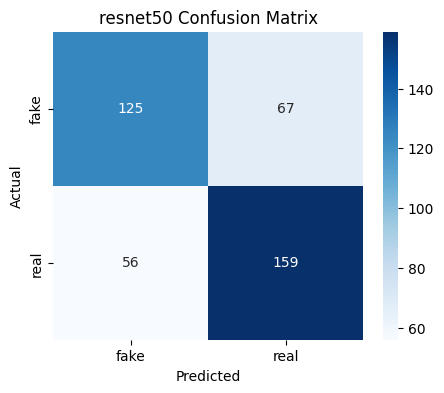

In [ ]:
from torchvision.models import resnet50
# Define loss function
criterion = nn.CrossEntropyLoss()

model_resnet = resnet50(pretrained=True)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, 2)

train_and_evaluate_model(model_resnet, "resnet50")


In [ ]:
# Save the full model (state_dict only)
model_save_path = "/content/resnet50_deepfake_model.pth"
torch.save(model_resnet.state_dict(), model_save_path)
print(f"✅ Model saved at: {model_save_path}")

✅ Model saved at: /content/resnet50_deepfake_model.pth


[efficientnet_b0] Epoch 1/30, Loss: 0.6845
[efficientnet_b0] Epoch 2/30, Loss: 0.6364
[efficientnet_b0] Epoch 3/30, Loss: 0.6090
[efficientnet_b0] Epoch 4/30, Loss: 0.6026
[efficientnet_b0] Epoch 5/30, Loss: 0.5614
[efficientnet_b0] Epoch 6/30, Loss: 0.5379
[efficientnet_b0] Epoch 7/30, Loss: 0.5027
[efficientnet_b0] Epoch 8/30, Loss: 0.4852
[efficientnet_b0] Epoch 9/30, Loss: 0.4384
[efficientnet_b0] Epoch 10/30, Loss: 0.4058
[efficientnet_b0] Epoch 11/30, Loss: 0.3630
[efficientnet_b0] Epoch 12/30, Loss: 0.3618
[efficientnet_b0] Epoch 13/30, Loss: 0.3518
[efficientnet_b0] Epoch 14/30, Loss: 0.3585
[efficientnet_b0] Epoch 15/30, Loss: 0.3449
[efficientnet_b0] Epoch 16/30, Loss: 0.3265
[efficientnet_b0] Epoch 17/30, Loss: 0.3216
[efficientnet_b0] Epoch 18/30, Loss: 0.3268
[efficientnet_b0] Epoch 19/30, Loss: 0.3222
[efficientnet_b0] Epoch 20/30, Loss: 0.3167
[efficientnet_b0] Epoch 21/30, Loss: 0.2979
[efficientnet_b0] Epoch 22/30, Loss: 0.3077
[efficientnet_b0] Epoch 23/30, Loss: 0.30

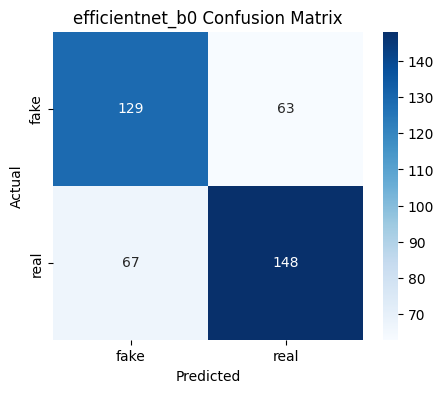

In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch.nn as nn

# Fix deprecated pretrained API
weights = EfficientNet_B0_Weights.DEFAULT
model_effnet = efficientnet_b0(weights=weights)

# Modify output layer for 2 classes
model_effnet.classifier[1] = nn.Linear(model_effnet.classifier[1].in_features, 2)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Train
train_and_evaluate_model(model_effnet, "efficientnet_b0")

In [ ]:
import torch
from google.colab import files

# Save the model
model_save_path = "/content/efficientnet_b0_deepfake_model.pth"
torch.save(model_effnet.state_dict(), model_save_path)
print(f"✅ Model saved at: {model_save_path}")

# Download the model to your local system
files.download(model_save_path)

✅ Model saved at: /content/efficientnet_b0_deepfake_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 120MB/s]


[vgg16] Epoch 1/30, Loss: 0.7038
[vgg16] Epoch 2/30, Loss: 0.6814
[vgg16] Epoch 3/30, Loss: 0.6701
[vgg16] Epoch 4/30, Loss: 0.6582
[vgg16] Epoch 5/30, Loss: 0.6718
[vgg16] Epoch 6/30, Loss: 0.6541
[vgg16] Epoch 7/30, Loss: 0.6450
[vgg16] Epoch 8/30, Loss: 0.6457
[vgg16] Epoch 9/30, Loss: 0.6380
[vgg16] Epoch 10/30, Loss: 0.6281
[vgg16] Epoch 11/30, Loss: 0.5967
[vgg16] Epoch 12/30, Loss: 0.5834
[vgg16] Epoch 13/30, Loss: 0.5690
[vgg16] Epoch 14/30, Loss: 0.5593
[vgg16] Epoch 15/30, Loss: 0.5462
[vgg16] Epoch 16/30, Loss: 0.5250
[vgg16] Epoch 17/30, Loss: 0.5180
[vgg16] Epoch 18/30, Loss: 0.5106
[vgg16] Epoch 19/30, Loss: 0.5067
[vgg16] Epoch 20/30, Loss: 0.4900
[vgg16] Epoch 21/30, Loss: 0.4671
[vgg16] Epoch 22/30, Loss: 0.4573
[vgg16] Epoch 23/30, Loss: 0.4688
[vgg16] Epoch 24/30, Loss: 0.4611
[vgg16] Epoch 25/30, Loss: 0.4560
[vgg16] Epoch 26/30, Loss: 0.4531
[vgg16] Epoch 27/30, Loss: 0.4424
[vgg16] Epoch 28/30, Loss: 0.4579
[vgg16] Epoch 29/30, Loss: 0.4557
[vgg16] Epoch 30/30, Lo

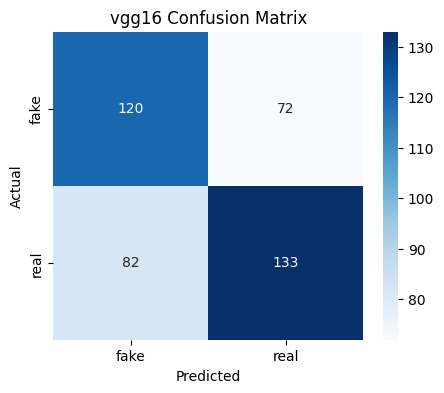

In [ ]:
from torchvision.models import vgg16

model_vgg = vgg16(pretrained=True)
model_vgg.classifier[6] = nn.Linear(model_vgg.classifier[6].in_features, 2)

train_and_evaluate_model(model_vgg, "vgg16")


In [ ]:
import torch
from google.colab import files

# Save the model
model_save_path = "/content/vgg16_deepfake_model.pth"
torch.save(model_vgg.state_dict(), model_save_path)
print(f"✅ Model saved at: {model_save_path}")

# Download the model to your local system
files.download(model_save_path)

✅ Model saved at: /content/vgg16_deepfake_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 140MB/s]


[densenet121] Epoch 1/30, Loss: 0.6778
[densenet121] Epoch 2/30, Loss: 0.5986
[densenet121] Epoch 3/30, Loss: 0.5739
[densenet121] Epoch 4/30, Loss: 0.5221
[densenet121] Epoch 5/30, Loss: 0.4709
[densenet121] Epoch 6/30, Loss: 0.4488
[densenet121] Epoch 7/30, Loss: 0.4119
[densenet121] Epoch 8/30, Loss: 0.3421
[densenet121] Epoch 9/30, Loss: 0.3143
[densenet121] Epoch 10/30, Loss: 0.2947
[densenet121] Epoch 11/30, Loss: 0.1969
[densenet121] Epoch 12/30, Loss: 0.1636
[densenet121] Epoch 13/30, Loss: 0.1484
[densenet121] Epoch 14/30, Loss: 0.1429
[densenet121] Epoch 15/30, Loss: 0.1233
[densenet121] Epoch 16/30, Loss: 0.1240
[densenet121] Epoch 17/30, Loss: 0.1227
[densenet121] Epoch 18/30, Loss: 0.1132
[densenet121] Epoch 19/30, Loss: 0.1164
[densenet121] Epoch 20/30, Loss: 0.1020
[densenet121] Epoch 21/30, Loss: 0.0974
[densenet121] Epoch 22/30, Loss: 0.1018
[densenet121] Epoch 23/30, Loss: 0.1017
[densenet121] Epoch 24/30, Loss: 0.0927
[densenet121] Epoch 25/30, Loss: 0.0911
[densenet

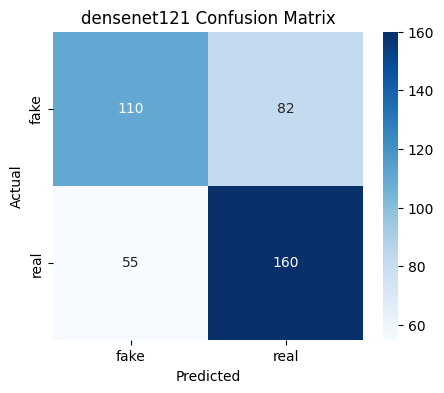

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from torchvision.models import densenet121, DenseNet121_Weights

weights = DenseNet121_Weights.DEFAULT
model_dense = densenet121(weights=weights)
model_dense.classifier = nn.Linear(model_dense.classifier.in_features, 2)

train_and_evaluate_model(model_dense, "densenet121")

# Auto-download
torch.save(model_dense.state_dict(), "/content/densenet121_deepfake_model.pth")
files.download("/content/densenet121_deepfake_model.pth")


Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 100MB/s]


[efficientnet_b1] Epoch 1/30, Loss: 0.6897
[efficientnet_b1] Epoch 2/30, Loss: 0.6723
[efficientnet_b1] Epoch 3/30, Loss: 0.6538
[efficientnet_b1] Epoch 4/30, Loss: 0.6336
[efficientnet_b1] Epoch 5/30, Loss: 0.6136
[efficientnet_b1] Epoch 6/30, Loss: 0.5918
[efficientnet_b1] Epoch 7/30, Loss: 0.5652
[efficientnet_b1] Epoch 8/30, Loss: 0.5392
[efficientnet_b1] Epoch 9/30, Loss: 0.5164
[efficientnet_b1] Epoch 10/30, Loss: 0.5005
[efficientnet_b1] Epoch 11/30, Loss: 0.4602
[efficientnet_b1] Epoch 12/30, Loss: 0.4593
[efficientnet_b1] Epoch 13/30, Loss: 0.4448
[efficientnet_b1] Epoch 14/30, Loss: 0.4413
[efficientnet_b1] Epoch 15/30, Loss: 0.4412
[efficientnet_b1] Epoch 16/30, Loss: 0.4382
[efficientnet_b1] Epoch 17/30, Loss: 0.4293
[efficientnet_b1] Epoch 18/30, Loss: 0.4267
[efficientnet_b1] Epoch 19/30, Loss: 0.4188
[efficientnet_b1] Epoch 20/30, Loss: 0.4174
[efficientnet_b1] Epoch 21/30, Loss: 0.4203
[efficientnet_b1] Epoch 22/30, Loss: 0.4204
[efficientnet_b1] Epoch 23/30, Loss: 0.43

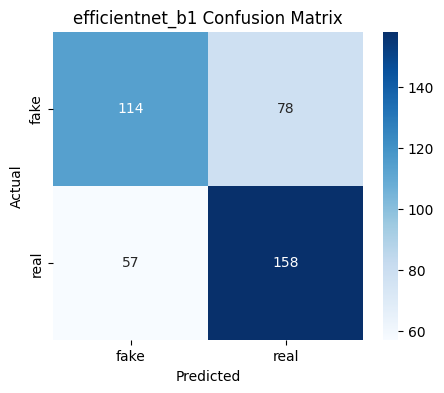

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights
from google.colab import files

weights = EfficientNet_B1_Weights.DEFAULT
model_effnet_b1 = efficientnet_b1(weights=weights)
model_effnet_b1.classifier[1] = nn.Linear(model_effnet_b1.classifier[1].in_features, 2)

train_and_evaluate_model(model_effnet_b1, "efficientnet_b1")

# Save and download
torch.save(model_effnet_b1.state_dict(), "/content/efficientnet_b1_deepfake_model.pth")
files.download("/content/efficientnet_b1_deepfake_model.pth")


Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 116MB/s]


[efficientnet_b4] Epoch 1/30, Loss: 0.6895
[efficientnet_b4] Epoch 2/30, Loss: 0.6761
[efficientnet_b4] Epoch 3/30, Loss: 0.6700
[efficientnet_b4] Epoch 4/30, Loss: 0.6557
[efficientnet_b4] Epoch 5/30, Loss: 0.6377
[efficientnet_b4] Epoch 6/30, Loss: 0.6264
[efficientnet_b4] Epoch 7/30, Loss: 0.6086
[efficientnet_b4] Epoch 8/30, Loss: 0.5902
[efficientnet_b4] Epoch 9/30, Loss: 0.5737
[efficientnet_b4] Epoch 10/30, Loss: 0.5584
[efficientnet_b4] Epoch 11/30, Loss: 0.5298
[efficientnet_b4] Epoch 12/30, Loss: 0.5274
[efficientnet_b4] Epoch 13/30, Loss: 0.5341
[efficientnet_b4] Epoch 14/30, Loss: 0.5327
[efficientnet_b4] Epoch 15/30, Loss: 0.5211
[efficientnet_b4] Epoch 16/30, Loss: 0.5262
[efficientnet_b4] Epoch 17/30, Loss: 0.5204
[efficientnet_b4] Epoch 18/30, Loss: 0.5233
[efficientnet_b4] Epoch 19/30, Loss: 0.5009
[efficientnet_b4] Epoch 20/30, Loss: 0.5132
[efficientnet_b4] Epoch 21/30, Loss: 0.5049
[efficientnet_b4] Epoch 22/30, Loss: 0.5061
[efficientnet_b4] Epoch 23/30, Loss: 0.53

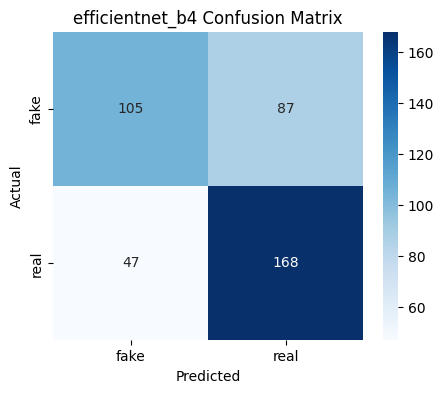

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights

weights = EfficientNet_B4_Weights.DEFAULT
model_effnet_b4 = efficientnet_b4(weights=weights)
model_effnet_b4.classifier[1] = nn.Linear(model_effnet_b4.classifier[1].in_features, 2)

train_and_evaluate_model(model_effnet_b4, "efficientnet_b4")

# Save and download
torch.save(model_effnet_b4.state_dict(), "/content/efficientnet_b4_deepfake_model.pth")
files.download("/content/efficientnet_b4_deepfake_model.pth")


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
import torch

torch.cuda.empty_cache()
print("✅ GPU cache cleared.")


✅ GPU cache cleared.


Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-1a07897c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-1a07897c.pth
100%|██████████| 117M/117M [00:01<00:00, 79.2MB/s]


[efficientnet_b5] Epoch 1/30, Loss: 0.6729
[efficientnet_b5] Epoch 2/30, Loss: 0.6297
[efficientnet_b5] Epoch 3/30, Loss: 0.5953
[efficientnet_b5] Epoch 4/30, Loss: 0.5494
[efficientnet_b5] Epoch 5/30, Loss: 0.4956
[efficientnet_b5] Epoch 6/30, Loss: 0.4514
[efficientnet_b5] Epoch 7/30, Loss: 0.3942
[efficientnet_b5] Epoch 8/30, Loss: 0.3665
[efficientnet_b5] Epoch 9/30, Loss: 0.3421
[efficientnet_b5] Epoch 10/30, Loss: 0.2835
[efficientnet_b5] Epoch 11/30, Loss: 0.2405
[efficientnet_b5] Epoch 12/30, Loss: 0.2237
[efficientnet_b5] Epoch 13/30, Loss: 0.2128
[efficientnet_b5] Epoch 14/30, Loss: 0.1961
[efficientnet_b5] Epoch 15/30, Loss: 0.1872
[efficientnet_b5] Epoch 16/30, Loss: 0.1630
[efficientnet_b5] Epoch 17/30, Loss: 0.1468
[efficientnet_b5] Epoch 18/30, Loss: 0.1383
[efficientnet_b5] Epoch 19/30, Loss: 0.1432
[efficientnet_b5] Epoch 20/30, Loss: 0.1328
[efficientnet_b5] Epoch 21/30, Loss: 0.1444
[efficientnet_b5] Epoch 22/30, Loss: 0.1234
[efficientnet_b5] Epoch 23/30, Loss: 0.13

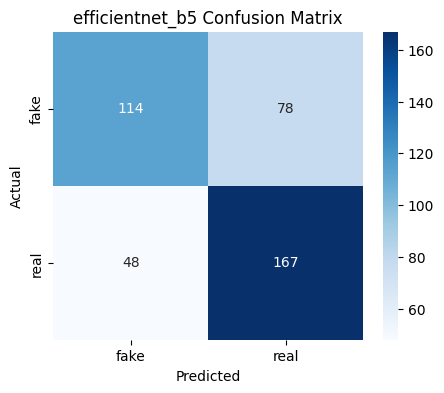

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights
import torch.nn as nn
from google.colab import files

# Load EfficientNet-B5
weights = EfficientNet_B5_Weights.DEFAULT
model_effnet_b5 = efficientnet_b5(weights=weights)
model_effnet_b5.classifier[1] = nn.Linear(model_effnet_b5.classifier[1].in_features, 2)
model_effnet_b5 = model_effnet_b5.to(device)

# Train and evaluate
train_and_evaluate_model(model_effnet_b5, "efficientnet_b5")

# Save and download
torch.save(model_effnet_b5.state_dict(), "/content/efficientnet_b5_deepfake_model.pth")
files.download("/content/efficientnet_b5_deepfake_model.pth")

Downloading: "https://download.pytorch.org/models/efficientnet_b6_lukemelas-24a108a5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b6_lukemelas-24a108a5.pth
100%|██████████| 165M/165M [00:01<00:00, 90.3MB/s]


[efficientnet_b6] Epoch 1/30, Loss: 0.6845
[efficientnet_b6] Epoch 2/30, Loss: 0.6577
[efficientnet_b6] Epoch 3/30, Loss: 0.6305
[efficientnet_b6] Epoch 4/30, Loss: 0.5904
[efficientnet_b6] Epoch 5/30, Loss: 0.5544
[efficientnet_b6] Epoch 6/30, Loss: 0.5218
[efficientnet_b6] Epoch 7/30, Loss: 0.4617
[efficientnet_b6] Epoch 8/30, Loss: 0.4295
[efficientnet_b6] Epoch 9/30, Loss: 0.4043
[efficientnet_b6] Epoch 10/30, Loss: 0.3582
[efficientnet_b6] Epoch 11/30, Loss: 0.2998
[efficientnet_b6] Epoch 12/30, Loss: 0.2532
[efficientnet_b6] Epoch 13/30, Loss: 0.2575
[efficientnet_b6] Epoch 14/30, Loss: 0.2240
[efficientnet_b6] Epoch 15/30, Loss: 0.2115
[efficientnet_b6] Epoch 16/30, Loss: 0.2017
[efficientnet_b6] Epoch 17/30, Loss: 0.2006
[efficientnet_b6] Epoch 18/30, Loss: 0.1534
[efficientnet_b6] Epoch 19/30, Loss: 0.1545
[efficientnet_b6] Epoch 20/30, Loss: 0.1409
[efficientnet_b6] Epoch 21/30, Loss: 0.1475
[efficientnet_b6] Epoch 22/30, Loss: 0.1377
[efficientnet_b6] Epoch 23/30, Loss: 0.15

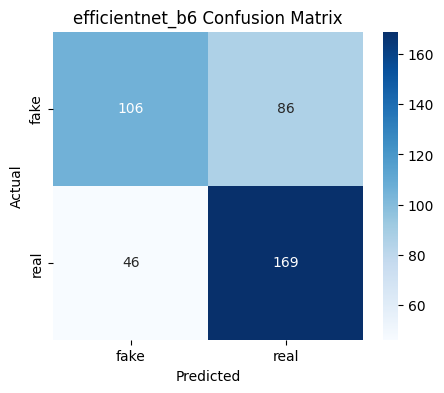

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from torchvision.models import efficientnet_b6, EfficientNet_B6_Weights
import torch.nn as nn
from google.colab import files

# === Load EfficientNet-B6 with pretrained weights
weights = EfficientNet_B6_Weights.DEFAULT
model_effnet_b6 = efficientnet_b6(weights=weights)

# === Update final layer for binary classification (real/fake)
model_effnet_b6.classifier[1] = nn.Linear(model_effnet_b6.classifier[1].in_features, 2)
model_effnet_b6 = model_effnet_b6.to(device)

# === Optional: Reduce batch size if memory error occurs
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# === Train and evaluate
train_and_evaluate_model(model_effnet_b6, "efficientnet_b6")

# === Save and download the model
torch.save(model_effnet_b6.state_dict(), "/content/efficientnet_b6_deepfake_model.pth")
files.download("/content/efficientnet_b6_deepfake_model.pth")

#Advanced model..didn't experimented due to lack of resources

In [ ]:
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights

weights = EfficientNet_B7_Weights.DEFAULT
model_effnet_b7 = efficientnet_b7(weights=weights)
model_effnet_b7.classifier[1] = nn.Linear(model_effnet_b7.classifier[1].in_features, 2)

train_and_evaluate_model(model_effnet_b7, "efficientnet_b7")

# Save and download
torch.save(model_effnet_b7.state_dict(), "/content/efficientnet_b7_deepfake_model.pth")
files.download("/content/efficientnet_b7_deepfake_model.pth")


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 2.12 MiB is free. Process 40269 has 14.74 GiB memory in use. Of the allocated memory 14.00 GiB is allocated by PyTorch, and 599.40 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
from google.colab import files
import torch.nn as nn

# Load pre-trained ConvNeXt
weights = ConvNeXt_Tiny_Weights.DEFAULT
model_convnext = convnext_tiny(weights=weights)
model_convnext.classifier[2] = nn.Linear(model_convnext.classifier[2].in_features, 2)
model_convnext = model_convnext.to(device)

# Train and evaluate
train_and_evaluate_model(model_convnext, "convnext_tiny")

# Save and auto-download
torch.save(model_convnext.state_dict(), "/content/convnext_tiny_deepfake_model.pth")
files.download("/content/convnext_tiny_deepfake_model.pth")

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 131MB/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 2.12 MiB is free. Process 40269 has 14.74 GiB memory in use. Of the allocated memory 14.00 GiB is allocated by PyTorch, and 599.56 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
from torchvision.models import swin_t, Swin_T_Weights

# Load Swin Tiny
weights = Swin_T_Weights.DEFAULT
model_swin = swin_t(weights=weights)
model_swin.head = nn.Linear(model_swin.head.in_features, 2)
model_swin = model_swin.to(device)

# Train and evaluate
train_and_evaluate_model(model_swin, "swin_transformer_tiny")

# Save and auto-download
torch.save(model_swin.state_dict(), "/content/swin_transformer_tiny_deepfake_model.pth")
files.download("/content/swin_transformer_tiny_deepfake_model.pth")

Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:01<00:00, 106MB/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 2.12 MiB is free. Process 40269 has 14.74 GiB memory in use. Of the allocated memory 14.00 GiB is allocated by PyTorch, and 599.54 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
from torchvision.models import regnet_y_16gf, RegNet_Y_16GF_Weights
from google.colab import files

# Load RegNet with pretrained weights
weights = RegNet_Y_16GF_Weights.DEFAULT
model_regnet = regnet_y_16gf(weights=weights)
model_regnet.fc = nn.Linear(model_regnet.fc.in_features, 2)
model_regnet = model_regnet.to(device)

# Train and evaluate
train_and_evaluate_model(model_regnet, "regnet_y_16gf")

# Save and auto-download
torch.save(model_regnet.state_dict(), "/content/regnet_y_16gf_deepfake_model.pth")
files.download("/content/regnet_y_16gf_deepfake_model.pth")

Downloading: "https://download.pytorch.org/models/regnet_y_16gf-3e4a00f9.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_16gf-3e4a00f9.pth
100%|██████████| 319M/319M [00:02<00:00, 148MB/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 2.12 MiB is free. Process 40269 has 14.74 GiB memory in use. Of the allocated memory 14.00 GiB is allocated by PyTorch, and 599.47 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
!pip install timm

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

[seresnet50] Epoch 1/30, Loss: 0.6854
[seresnet50] Epoch 2/30, Loss: 0.6696
[seresnet50] Epoch 3/30, Loss: 0.6564
[seresnet50] Epoch 4/30, Loss: 0.6432
[seresnet50] Epoch 5/30, Loss: 0.6264
[seresnet50] Epoch 6/30, Loss: 0.6323
[seresnet50] Epoch 7/30, Loss: 0.6037
[seresnet50] Epoch 8/30, Loss: 0.5935
[seresnet50] Epoch 9/30, Loss: 0.5891
[seresnet50] Epoch 10/30, Loss: 0.5684
[seresnet50] Epoch 11/30, Loss: 0.5449
[seresnet50] Epoch 12/30, Loss: 0.5499
[seresnet50] Epoch 13/30, Loss: 0.5297
[seresnet50] Epoch 14/30, Loss: 0.5280
[seresnet50] Epoch 15/30, Loss: 0.5291
[seresnet50] Epoch 16/30, Loss: 0.5360
[seresnet50] Epoch 17/30, Loss: 0.5061
[seresnet50] Epoch 18/30, Loss: 0.5103
[seresnet50] Epoch 19/30, Loss: 0.5091
[seresnet50] Epoch 20/30, Loss: 0.5142
[seresnet50] Epoch 21/30, Loss: 0.5090
[seresnet50] Epoch 22/30, Loss: 0.5239
[seresnet50] Epoch 23/30, Loss: 0.5057
[seresnet50] Epoch 24/30, Loss: 0.4977
[seresnet50] Epoch 25/30, Loss: 0.5100
[seresnet50] Epoch 26/30, Loss: 0.

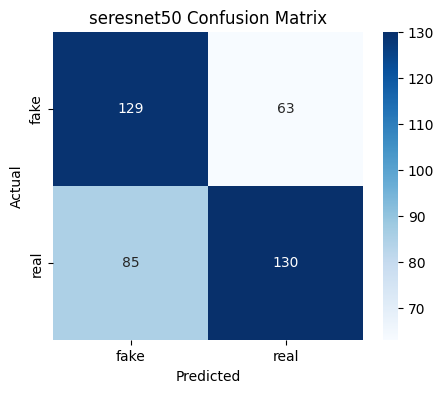

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import timm
from google.colab import files

# Load pretrained SE-ResNet50
model_seresnet = timm.create_model("seresnet50", pretrained=True, num_classes=2)
model_seresnet = model_seresnet.to(device)

# Train and evaluate
train_and_evaluate_model(model_seresnet, "seresnet50")

# Save and download
torch.save(model_seresnet.state_dict(), "/content/seresnet50_deepfake_model.pth")
files.download("/content/seresnet50_deepfake_model.pth")


# Data Download

In [ ]:
import shutil
from google.colab import files

# Zip the entire dataset folder
shutil.make_archive("/content/FaceSplit", 'zip', "/content/FaceSplit")

# Download the zip file
files.download("/content/FaceSplit.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import torch
import torch.nn as nn
from transformers import ViTForImageClassification
from torchvision import models
import timm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

# === Unified Fine-Tune Script with Evaluation and Auto-Download
def fine_tune_model(model_type, pth_path, model_name, classifier_key, epochs=5, lr=1e-5, freeze_base=True):
    # === Re-initialize correct model structure
    if model_type == "vit":
        model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")
        model.classifier = nn.Linear(model.classifier.in_features, 2)
    elif model_type == "resnet50":
        model = models.resnet50(weights=None)
        model.fc = nn.Linear(model.fc.in_features, 2)
    elif model_type == "vgg16":
        model = models.vgg16(weights=None)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)
    elif model_type == "densenet121":
        model = models.densenet121(weights=None)
        model.classifier = nn.Linear(model.classifier.in_features, 2)
    elif model_type.startswith("efficientnet"):
        effnet_fn = getattr(models, model_type)
        model = effnet_fn(weights=None)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
    elif model_type == "seresnet18":
        model = timm.create_model("seresnet18", pretrained=False, num_classes=2)
    else:
        raise ValueError("Unsupported model_type")

    # === Load pre-trained weights
    model.load_state_dict(torch.load(pth_path, map_location=device))
    model = model.to(device)

    # === Optionally freeze base
    if freeze_base:
        for name, param in model.named_parameters():
            if not any(k in name for k in classifier_key):
                param.requires_grad = False

    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

    # === Fine-Tuning
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            if hasattr(outputs, "logits"): outputs = outputs.logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        print(f"[{model_name}] Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

    # === Save and Download Fine-Tuned Model
    save_path = f"/content/{model_name}_fine_tuned.pth"
    torch.save(model.state_dict(), save_path)
    files.download(save_path)
    print(f"✅ Fine-tuned model saved and downloaded: {save_path}")

    # === Evaluation
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if hasattr(outputs, "logits"): outputs = outputs.logits
            probs = torch.softmax(outputs, dim=1)[:, 1]
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    # === Metrics
    print(f"\n📊 {model_name} Fine-Tuned Evaluation:\n")
    print(classification_report(y_true, y_pred, target_names=train_dataset.classes))
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_probs)
    print(f"✅ Accuracy: {acc:.2%}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")

    # === Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=train_dataset.classes,
                yticklabels=train_dataset.classes)
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return model

[vit] Epoch 1/5, Loss: 0.1470
[vit] Epoch 2/5, Loss: 0.1366
[vit] Epoch 3/5, Loss: 0.1481
[vit] Epoch 4/5, Loss: 0.1378
[vit] Epoch 5/5, Loss: 0.1501


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Fine-tuned model saved and downloaded: /content/vit_fine_tuned.pth

📊 vit Fine-Tuned Evaluation:

              precision    recall  f1-score   support

        fake       0.72      0.77      0.74       192
        real       0.78      0.74      0.76       215

    accuracy                           0.75       407
   macro avg       0.75      0.75      0.75       407
weighted avg       0.75      0.75      0.75       407

✅ Accuracy: 75.18%, F1: 0.7589, ROC-AUC: 0.8320


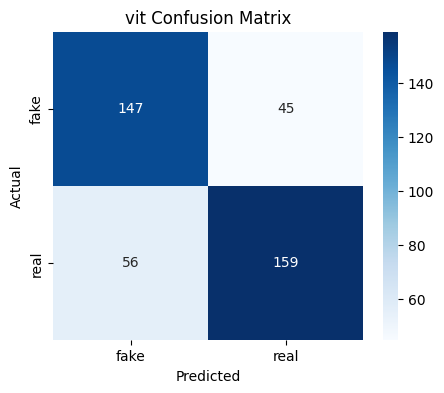

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [ ]:
fine_tune_model("vit", "/content/vit_deepfake_model.pth", "vit", classifier_key=["classifier"])

[resnet50] Epoch 1/5, Loss: 0.0886
[resnet50] Epoch 2/5, Loss: 0.0869
[resnet50] Epoch 3/5, Loss: 0.0882
[resnet50] Epoch 4/5, Loss: 0.0785
[resnet50] Epoch 5/5, Loss: 0.0816


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Fine-tuned model saved and downloaded: /content/resnet50_fine_tuned.pth

📊 resnet50 Fine-Tuned Evaluation:

              precision    recall  f1-score   support

        fake       0.70      0.62      0.66       192
        real       0.69      0.76      0.72       215

    accuracy                           0.69       407
   macro avg       0.69      0.69      0.69       407
weighted avg       0.69      0.69      0.69       407

✅ Accuracy: 69.29%, F1: 0.7228, ROC-AUC: 0.7625


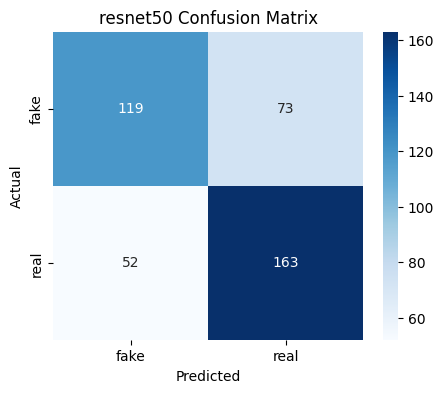

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
fine_tune_model("resnet50", "/content/resnet50_deepfake_model.pth", "resnet50", classifier_key=["fc"])

[vgg16] Epoch 1/5, Loss: 0.4419
[vgg16] Epoch 2/5, Loss: 0.4428
[vgg16] Epoch 3/5, Loss: 0.4550
[vgg16] Epoch 4/5, Loss: 0.4514
[vgg16] Epoch 5/5, Loss: 0.4579


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Fine-tuned model saved and downloaded: /content/vgg16_fine_tuned.pth

📊 vgg16 Fine-Tuned Evaluation:

              precision    recall  f1-score   support

        fake       0.59      0.62      0.61       192
        real       0.65      0.62      0.63       215

    accuracy                           0.62       407
   macro avg       0.62      0.62      0.62       407
weighted avg       0.62      0.62      0.62       407

✅ Accuracy: 62.16%, F1: 0.6333, ROC-AUC: 0.6715


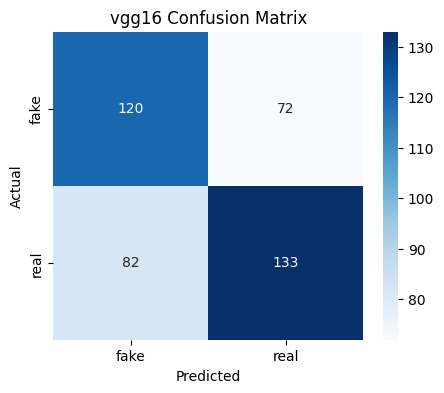

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
fine_tune_model("vgg16", "/content/vgg16_deepfake_model.pth", "vgg16", classifier_key=["classifier.6"])

In [ ]:
def fine_tune_model(model_type, model_name, classifier_key, epochs=5, lr=1e-5, freeze_base=True):
    # === Build full Google Drive path
    pth_path = f"/content/drive/MyDrive/ee_655_models/{model_name}_deepfake_model.pth"

    # === Re-initialize correct model structure
    if model_type == "vit":
        model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")
        model.classifier = nn.Linear(model.classifier.in_features, 2)
    elif model_type == "resnet50":
        model = models.resnet50(weights=None)
        model.fc = nn.Linear(model.fc.in_features, 2)
    elif model_type == "vgg16":
        model = models.vgg16(weights=None)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)
    elif model_type == "densenet121":
        model = models.densenet121(weights=None)
        model.classifier = nn.Linear(model.classifier.in_features, 2)
    elif model_type.startswith("efficientnet"):
        effnet_fn = getattr(models, model_type)
        model = effnet_fn(weights=None)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
    elif model_type == "seresnet50":
        model = timm.create_model("seresnet50", pretrained=False, num_classes=2)
    else:
        raise ValueError("Unsupported model_type")

    # === Load weights from Drive
    model.load_state_dict(torch.load(pth_path, map_location=device))
    model = model.to(device)

    # === Freeze base if needed
    if freeze_base:
        for name, param in model.named_parameters():
            if not any(k in name for k in classifier_key):
                param.requires_grad = False

    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

    # === Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            if hasattr(outputs, "logits"): outputs = outputs.logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        print(f"[{model_name}] Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

    # === Save to Drive
    save_path = f"/content/drive/MyDrive/ee_655_models/{model_name}_fine_tuned.pth"
    torch.save(model.state_dict(), save_path)
    print(f"✅ Fine-tuned model saved to: {save_path}")

    # === Evaluation (same as before)
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if hasattr(outputs, "logits"): outputs = outputs.logits
            probs = torch.softmax(outputs, dim=1)[:, 1]
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    print(f"\n📊 {model_name} Fine-Tuned Evaluation:\n")
    print(classification_report(y_true, y_pred, target_names=train_dataset.classes))
    print(f"✅ Accuracy: {accuracy_score(y_true, y_pred):.2%}")
    print(f"✅ F1 Score: {f1_score(y_true, y_pred):.4f}")
    print(f"✅ ROC-AUC: {roc_auc_score(y_true, y_probs):.4f}")

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=train_dataset.classes,
                yticklabels=train_dataset.classes)
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return model

[efficientnet_b0] Epoch 1/5, Loss: 0.3064
[efficientnet_b0] Epoch 2/5, Loss: 0.3135
[efficientnet_b0] Epoch 3/5, Loss: 0.3091
[efficientnet_b0] Epoch 4/5, Loss: 0.2946
[efficientnet_b0] Epoch 5/5, Loss: 0.3067
✅ Fine-tuned model saved to: /content/drive/MyDrive/ee_655_models/efficientnet_b0_fine_tuned.pth

📊 efficientnet_b0 Fine-Tuned Evaluation:

              precision    recall  f1-score   support

        fake       0.67      0.64      0.66       192
        real       0.69      0.72      0.71       215

    accuracy                           0.68       407
   macro avg       0.68      0.68      0.68       407
weighted avg       0.68      0.68      0.68       407

✅ Accuracy: 68.30%
✅ F1 Score: 0.7062
✅ ROC-AUC: 0.7375


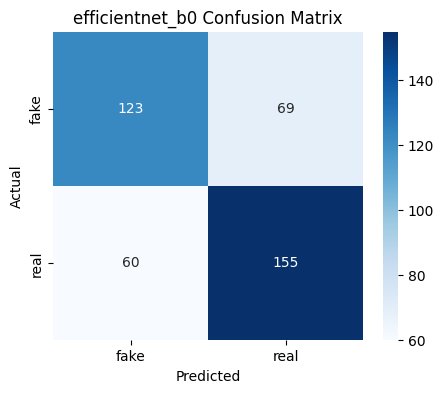

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
fine_tune_model("efficientnet_b0", "efficientnet_b0", classifier_key=["classifier.1"])

[efficientnet_b1] Epoch 1/5, Loss: 0.3965
[efficientnet_b1] Epoch 2/5, Loss: 0.4188
[efficientnet_b1] Epoch 3/5, Loss: 0.4198
[efficientnet_b1] Epoch 4/5, Loss: 0.4158
[efficientnet_b1] Epoch 5/5, Loss: 0.4068
✅ Fine-tuned model saved to: /content/drive/MyDrive/ee_655_models/efficientnet_b1_fine_tuned.pth

📊 efficientnet_b1 Fine-Tuned Evaluation:

              precision    recall  f1-score   support

        fake       0.67      0.60      0.64       192
        real       0.68      0.74      0.71       215

    accuracy                           0.68       407
   macro avg       0.68      0.67      0.67       407
weighted avg       0.68      0.68      0.67       407

✅ Accuracy: 67.57%
✅ F1 Score: 0.7067
✅ ROC-AUC: 0.7222


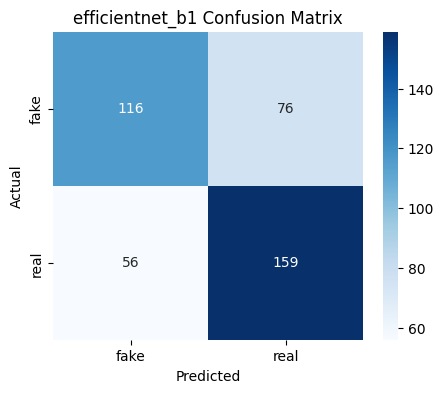

[efficientnet_b4] Epoch 1/5, Loss: 0.5088
[efficientnet_b4] Epoch 2/5, Loss: 0.5251
[efficientnet_b4] Epoch 3/5, Loss: 0.5146
[efficientnet_b4] Epoch 4/5, Loss: 0.5016
[efficientnet_b4] Epoch 5/5, Loss: 0.5080
✅ Fine-tuned model saved to: /content/drive/MyDrive/ee_655_models/efficientnet_b4_fine_tuned.pth

📊 efficientnet_b4 Fine-Tuned Evaluation:

              precision    recall  f1-score   support

        fake       0.70      0.54      0.61       192
        real       0.66      0.79      0.72       215

    accuracy                           0.67       407
   macro avg       0.68      0.67      0.66       407
weighted avg       0.68      0.67      0.67       407

✅ Accuracy: 67.32%
✅ F1 Score: 0.7188
✅ ROC-AUC: 0.7227


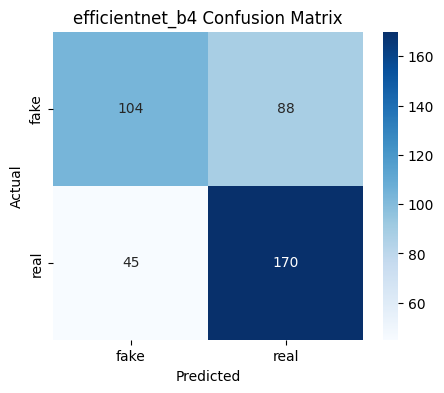

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [ ]:
# === EfficientNet-B1
fine_tune_model("efficientnet_b1", "efficientnet_b1", classifier_key=["classifier.1"])

# === EfficientNet-B4
fine_tune_model("efficientnet_b4", "efficientnet_b4", classifier_key=["classifier.1"])


[efficientnet_b6] Epoch 1/5, Loss: 0.0528
[efficientnet_b6] Epoch 2/5, Loss: 0.0751
[efficientnet_b6] Epoch 3/5, Loss: 0.0637
[efficientnet_b6] Epoch 4/5, Loss: 0.0556
[efficientnet_b6] Epoch 5/5, Loss: 0.0519
✅ Fine-tuned model saved to: /content/drive/MyDrive/ee_655_models/efficientnet_b6_fine_tuned.pth

📊 efficientnet_b6 Fine-Tuned Evaluation:

              precision    recall  f1-score   support

        fake       0.67      0.60      0.64       192
        real       0.68      0.74      0.71       215

    accuracy                           0.68       407
   macro avg       0.68      0.67      0.67       407
weighted avg       0.68      0.68      0.67       407

✅ Accuracy: 67.57%
✅ F1 Score: 0.7067
✅ ROC-AUC: 0.7444


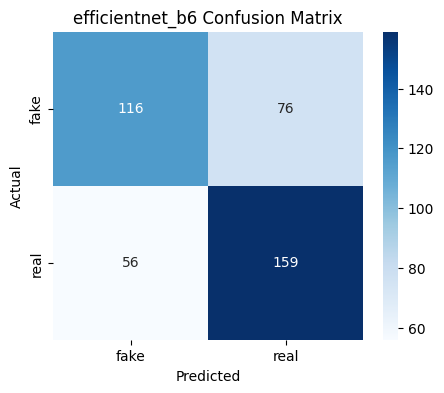

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=56, bias=False)
            (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(56, 14, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(14, 56, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [ ]:
# === EfficientNet-B6
fine_tune_model("efficientnet_b6", "efficientnet_b6", classifier_key=["classifier.1"])

[efficientnet_b5] Epoch 1/5, Loss: 0.0608
[efficientnet_b5] Epoch 2/5, Loss: 0.0725
[efficientnet_b5] Epoch 3/5, Loss: 0.0696
[efficientnet_b5] Epoch 4/5, Loss: 0.0724
[efficientnet_b5] Epoch 5/5, Loss: 0.0617
✅ Fine-tuned model saved to: /content/drive/MyDrive/ee_655_models/efficientnet_b5_fine_tuned.pth

📊 efficientnet_b5 Fine-Tuned Evaluation:

              precision    recall  f1-score   support

        fake       0.69      0.60      0.64       192
        real       0.68      0.76      0.72       215

    accuracy                           0.69       407
   macro avg       0.69      0.68      0.68       407
weighted avg       0.69      0.69      0.68       407

✅ Accuracy: 68.55%
✅ F1 Score: 0.7181
✅ ROC-AUC: 0.7299


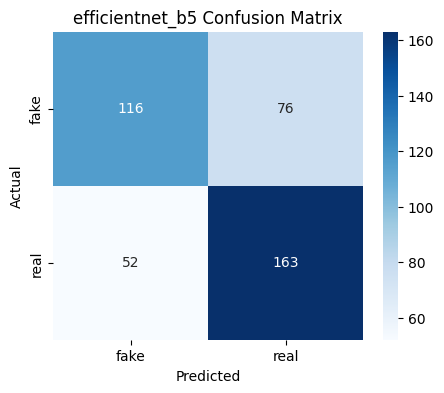

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [ ]:
# === EfficientNet-B5
fine_tune_model("efficientnet_b5", "efficientnet_b5", classifier_key=["classifier.1"])

[seresnet50] Epoch 1/5, Loss: 0.4647
[seresnet50] Epoch 2/5, Loss: 0.4632
[seresnet50] Epoch 3/5, Loss: 0.4742
[seresnet50] Epoch 4/5, Loss: 0.4643
[seresnet50] Epoch 5/5, Loss: 0.4866
✅ Fine-tuned model saved to: /content/drive/MyDrive/ee_655_models/seresnet50_fine_tuned.pth

📊 seresnet50 Fine-Tuned Evaluation:

              precision    recall  f1-score   support

        fake       0.60      0.65      0.62       192
        real       0.66      0.61      0.63       215

    accuracy                           0.63       407
   macro avg       0.63      0.63      0.63       407
weighted avg       0.63      0.63      0.63       407

✅ Accuracy: 62.65%
✅ F1 Score: 0.6329
✅ ROC-AUC: 0.6791


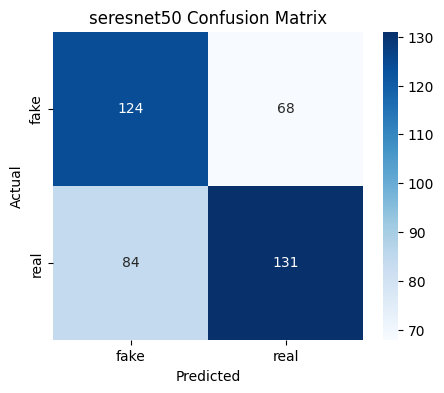

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [ ]:
# === SE-ResNet18
fine_tune_model("seresnet50", "seresnet50", classifier_key=["fc"])

[densenet121] Epoch 1/5, Loss: 0.0870
[densenet121] Epoch 2/5, Loss: 0.0715
[densenet121] Epoch 3/5, Loss: 0.0944
[densenet121] Epoch 4/5, Loss: 0.0967
[densenet121] Epoch 5/5, Loss: 0.0855
✅ Fine-tuned model saved to: /content/drive/MyDrive/ee_655_models/densenet121_fine_tuned.pth

📊 densenet121 Fine-Tuned Evaluation:

              precision    recall  f1-score   support

        fake       0.66      0.63      0.65       192
        real       0.68      0.71      0.70       215

    accuracy                           0.67       407
   macro avg       0.67      0.67      0.67       407
weighted avg       0.67      0.67      0.67       407

✅ Accuracy: 67.32%
✅ F1 Score: 0.6970
✅ ROC-AUC: 0.7294


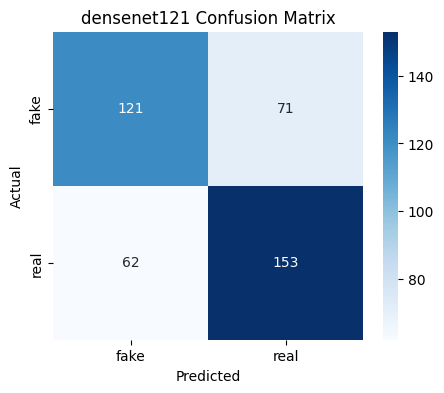

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
# === DenseNet121
fine_tune_model("densenet121", "densenet121", classifier_key=["classifier"])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive
